In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from hydra import compose, initialize

import jax
import jax.numpy as jnp
from jax import device_put
import flax

import numpy as np

In [3]:
%load_ext autoreload
%autoreload 1

%aimport main
%aimport train
%aimport data

from models import GLOW

In [4]:
initialize(config_path="configs", job_name="eval")
config = compose(config_name="default")

In [5]:
random_key = jax.random.PRNGKey(0)
model = GLOW(**config.model.params)

In [6]:
shape = (config.train.batch_size,config.data.image_size,config.data.image_size,config.data.num_channels)
with open('outputs/stickmanf/2021-08-31_23-58-42/train.num_epochs=60/weights/model_epoch=060.weights', 'rb') as f:
    params = model.init(random_key, jnp.zeros(shape))
    params = flax.serialization.from_bytes(params, f.read())

In [12]:
params['params']['flow_scale_1//step_1']

FrozenDict({
    ActNorm_0: {
        actnorm_mean: array([[[[-0.35316098, -0.35662287, -0.37363064, -0.34436816]]]],
              dtype=float32),
        actnorm_sigma: array([[[[2.18341  , 2.3398416, 2.2543645, 2.3108966]]]], dtype=float32),
    },
    InvertibleConv1x1_0: {
        L: array([[ 1.        ,  0.        ,  0.        ,  0.        ],
               [-0.07965233,  1.        ,  0.        ,  0.        ],
               [ 0.35436007, -0.48506305,  1.        ,  0.        ],
               [-0.439498  , -0.5220483 , -0.6453344 ,  1.        ]],
              dtype=float32),
        U: array([[ 0.        ,  0.07822594, -0.48268703,  0.20745455],
               [ 0.        ,  0.        ,  0.0039114 ,  0.56589437],
               [ 0.        ,  0.        ,  0.        ,  0.6448646 ],
               [ 0.        ,  0.        ,  0.        ,  0.        ]],
              dtype=float32),
        log_s: array([-0.16837098, -0.07254542,  0.04381901,  0.511343  ], dtype=float32),
    },
   

In [21]:
from functools import partial
from train import sample
from data import postprocess

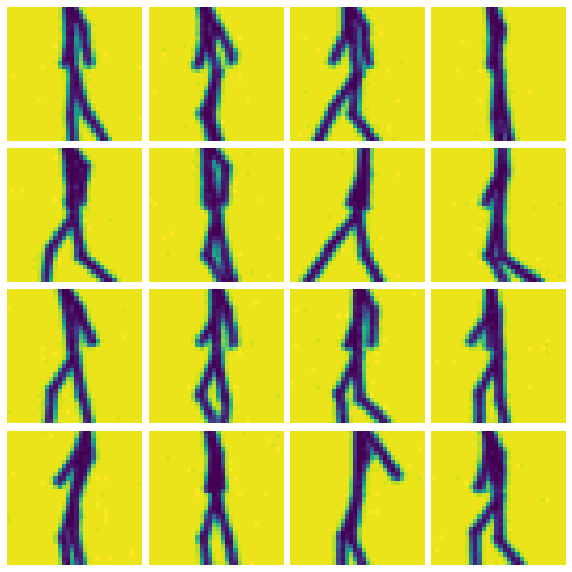

In [51]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(3), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]));

In [23]:
train_ds, val_ds = data.setup_data(config,show_grid=False)
del train_ds

20000 training images
312 training steps per epoch


In [24]:
from utils import plot_image_grid 

def reconstruct(model, params, batch):
    global config_dict
    x, z, logdets, priors = model.apply(params, batch, reverse=False)
    rec, *_ = model.apply(params, z[-1], z=z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(postprocess(batch, config_dict["num_bits"]), title="original")
    plot_image_grid(rec, title="reconstructions")

def interpolate(model, params, batch, num_samples=16, key=random_key):
    global config_dict
    i1, i2 = jax.random.choice(key, jnp.array(range(batch.shape[0])), shape=(2,), replace=False)
    in_ = np.stack([batch[i1], batch[i2]], axis=0)
    x, z, logdets, priors = model.apply(params, in_, reverse=False)
    # interpolate
    interpolated_z = []
    for zi in z:
        z_1, z_2 = zi[:2]
        interpolate = jnp.array([t * z_1 + (1 - t) * z_2 for t in np.linspace(0., 1., 16)])
        interpolated_z.append(interpolate)
    rec, *_ = model.apply(params, interpolated_z[-1], z=interpolated_z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(rec, title="Linear interpolation")

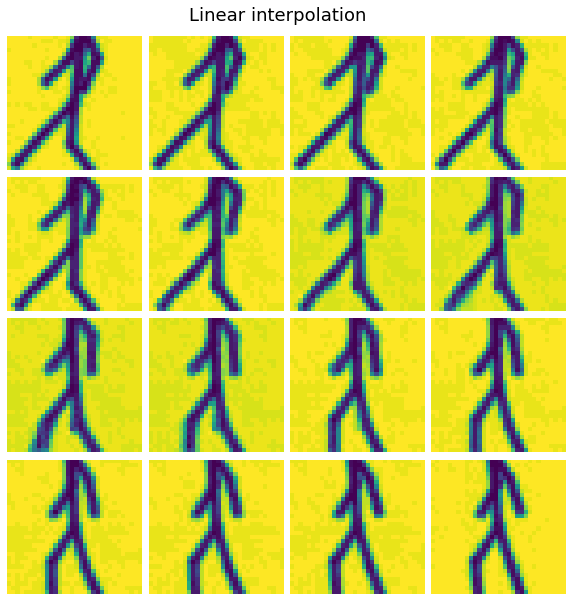

In [52]:
batch = next(val_ds)
interpolate(model, params, batch)

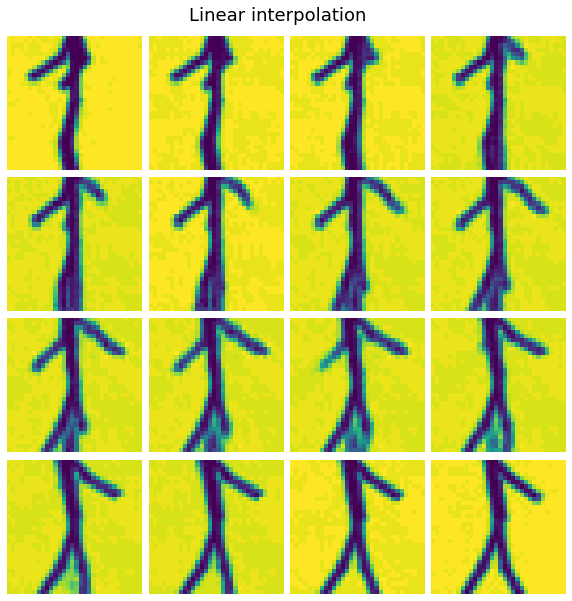

In [53]:
batch = next(val_ds)
interpolate(model, params, batch)

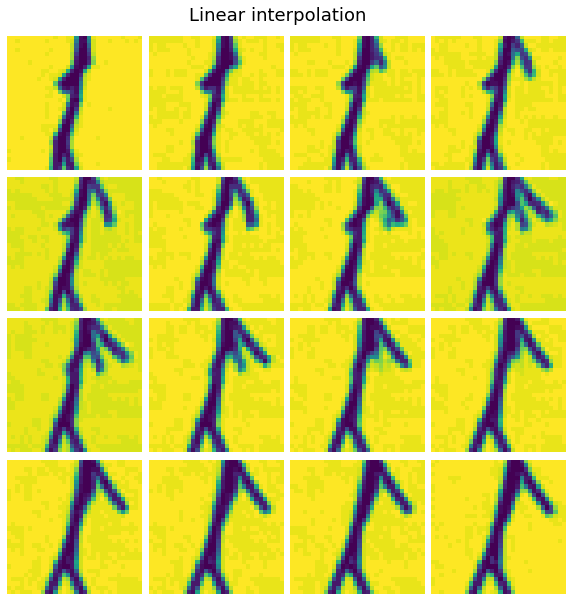

In [54]:
batch = next(val_ds)
interpolate(model, params, batch)

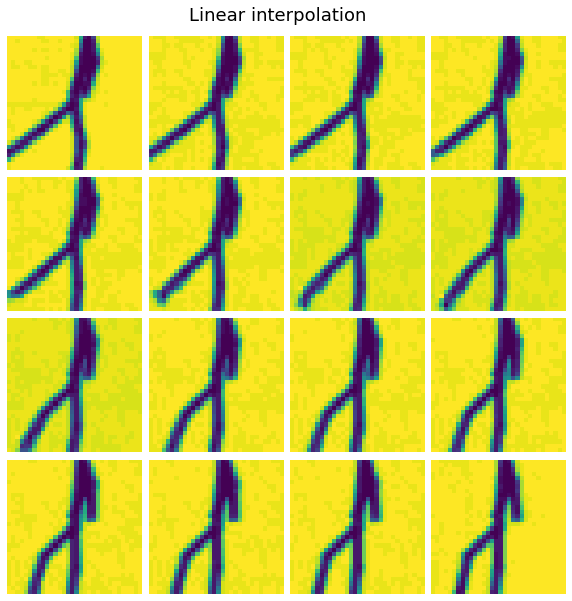

In [40]:
batch = next(val_ds)
interpolate(model, params, batch)

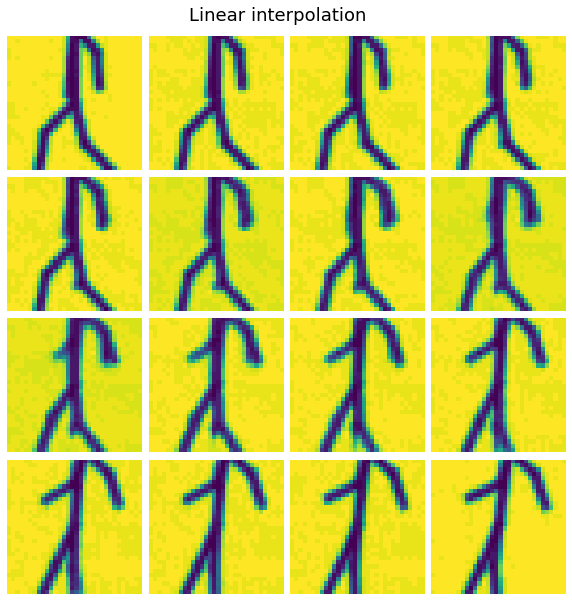

In [41]:
batch = next(val_ds)
interpolate(model, params, batch)

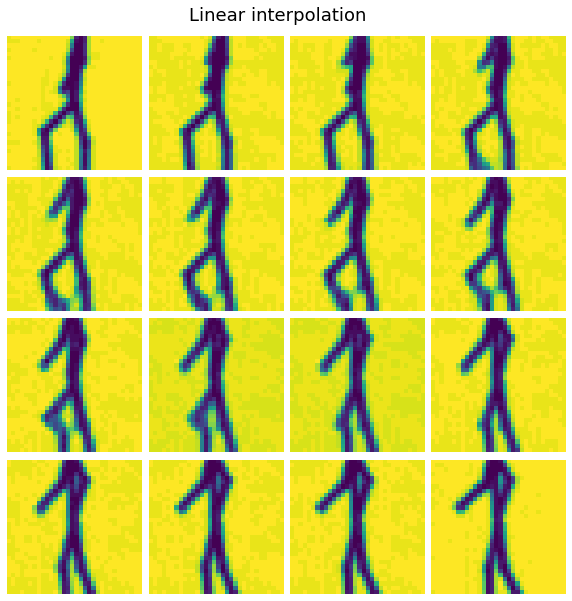

In [42]:
batch = next(val_ds)
interpolate(model, params, batch)

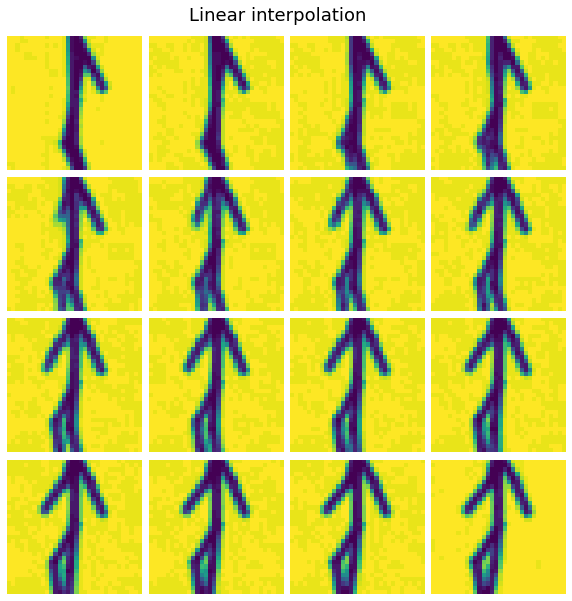

In [43]:
batch = next(val_ds)
interpolate(model, params, batch)

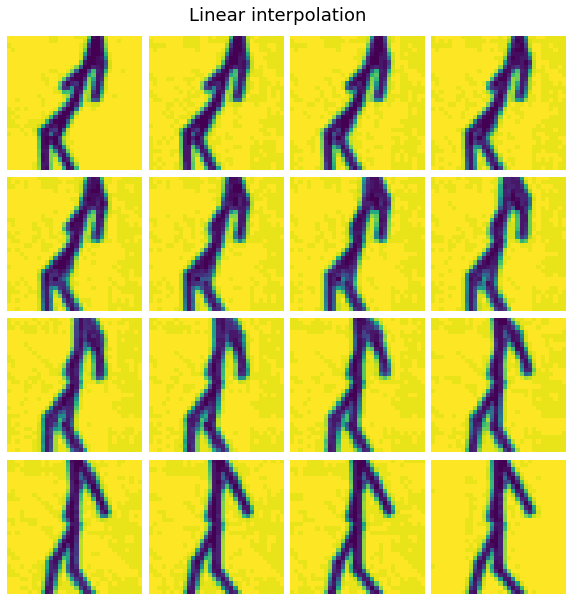

In [44]:
batch = next(val_ds)
interpolate(model, params, batch)

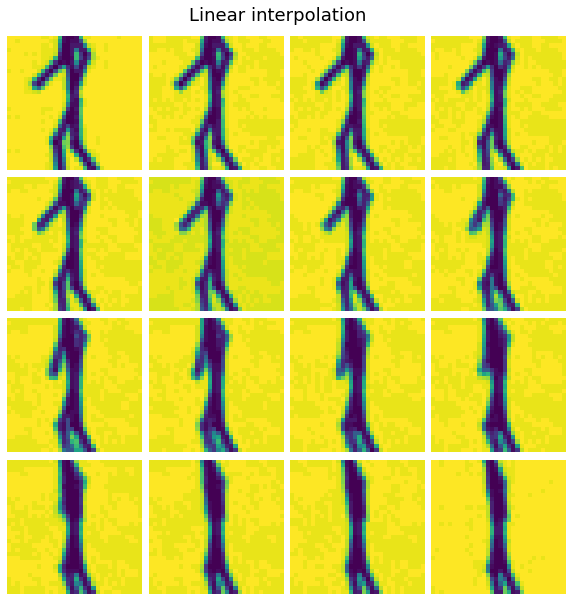

In [45]:
batch = next(val_ds)
interpolate(model, params, batch)

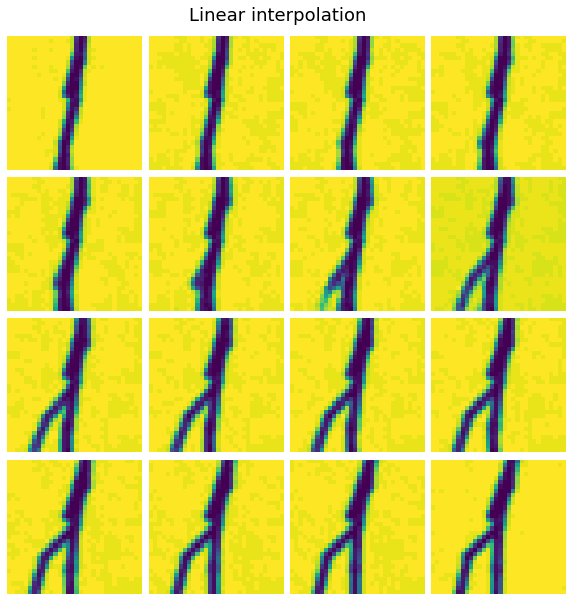

In [46]:
batch = next(val_ds)
interpolate(model, params, batch)